## Objective: to identify which customer will buy Insurance. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd ../gdrive/My Drive/Colab Notebooks/_Location Intelligence

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve

In [ ]:
# Functions

# Function to return Predicted values
def score_data(trained_model, x_vals):
    ypredict = trained_model.predict(x_vals)
    return ypredict

# Function to calculate Prediction accuracy of model
def model_accuracy(trained_model, variables, targets):
    accuracy_score = trained_model.score(variables, targets)
    return accuracy_score

# Function to generate Confusion matrix
def confusion_matrix_custom(act, predict):
  # Compute Confusion matrix
  print("Actual, Predicted Observations:  ",len(act), len(predict))
  anpn = 0
  anpy = 0
  aypn = 0
  aypy = 0
  
  for i in range(len(act)):
      if (act[i]==0 and predict[i]==0):
          anpn = anpn + 1
      elif (act[i]==0 and predict[i]==1):
          anpy = anpy + 1
      elif (act[i]==1 and predict[i]==0):
          aypn = aypn + 1
      else:
          aypy = aypy + 1
  # Confusoin matrix
  print ("--------------------------------------------")
  print ("Confusion Matrix")
  print ("--------------------------------------------")
  print ("              ", "Predicted N", "Predicted Y")
  print ("Actual N      ", anpn,"          ", anpy) 
  print ("Actual Y      ", aypn,"          ", aypy)
  print ("--------------------------------------------")
  print ("Total observations  :  ", anpn+anpy+aypn+aypy)
  print ("False Positives     :  ", anpy)
  print ("False Negatives     :  ", aypn)
  print ("Overall Accuracy    :  ", round((float(anpn+aypy)/float(anpn+anpy+aypn+aypy))*100, 2), "%")
  print ("Sensitivity/Recall  :  ", round((float(aypy)/float(aypn+aypy))*100, 2), "%")
  print ("Specificity         :  ", round((float(anpn)/float(anpn+anpy))*100, 2), "%")
  print ("Precision           :  ", round((float(aypy)/float(anpy+aypy))*100, 2), "%")
  print ("--------------------------------------------")

In [ ]:
data = pd.read_csv("Classification with FlightRoute of SpiceJet/AncillaryScoring_insurance.csv",encoding='latin-1')

### EDA & Preprocessing

In [ ]:
cols = data.columns

In [ ]:
data_classA = data[data['INS_FLAG'] == 0]
data_classB = data[data['INS_FLAG'] == 1]

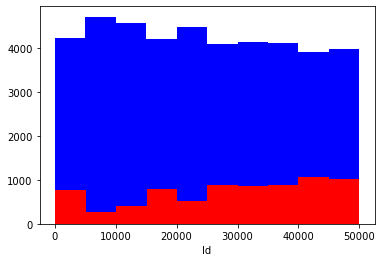

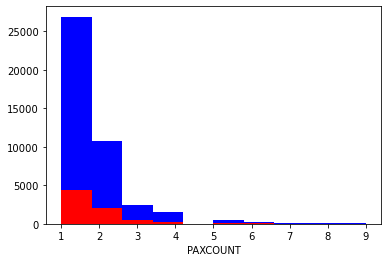

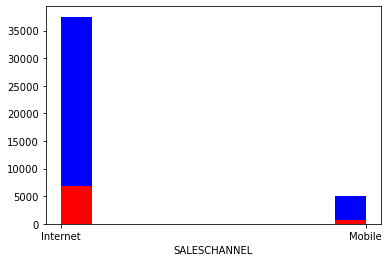

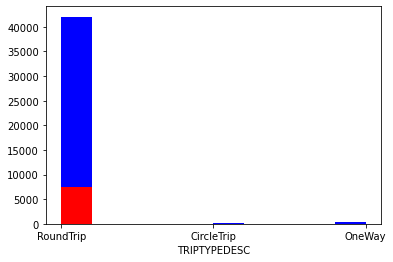

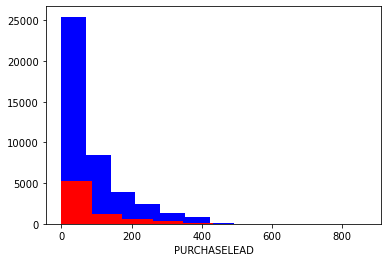

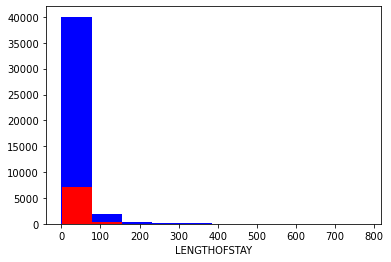

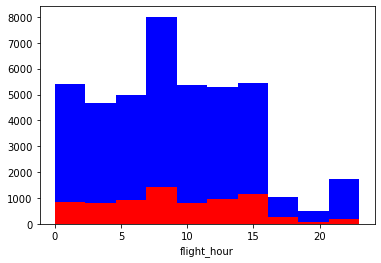

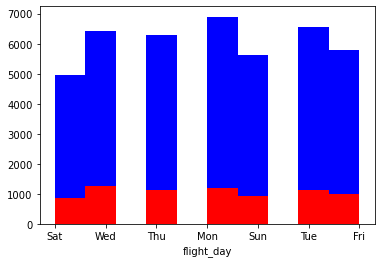

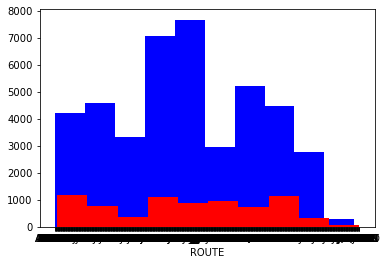

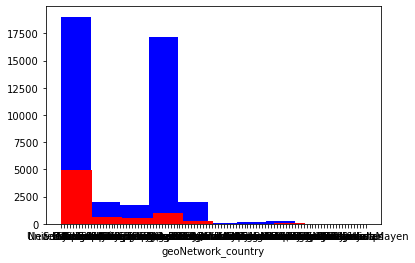

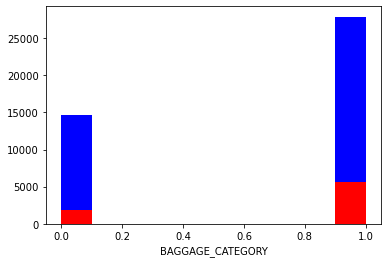

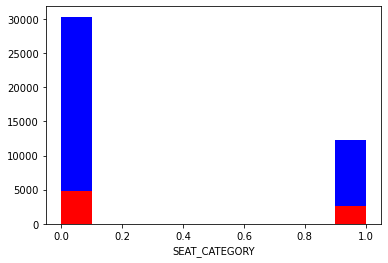

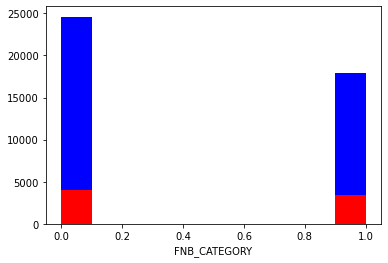

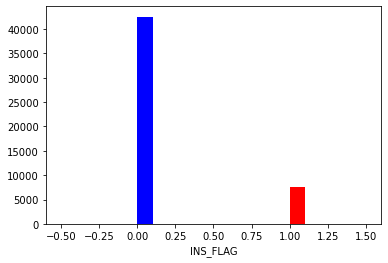

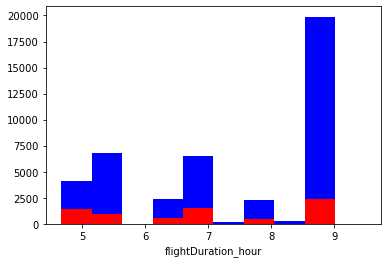

In [ ]:
# Visualizing the relation between numerical variables and target variable
for i in cols:
    plt.hist(data_classA[i],color='blue')
    plt.hist(data_classB[i], color='red')
    plt.xlabel(i)
    plt.show()

In [ ]:
# Removing ID column 
len(data['Id'].unique()) # 50000 , which is equal to the number of rows, this may be dropped

data.drop(['Id'], axis=1,inplace=True)
data.shape

(50000, 14)

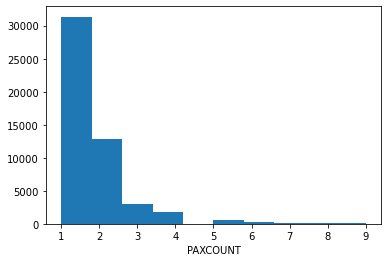

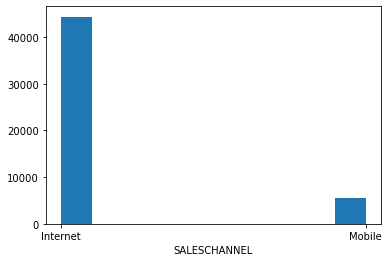

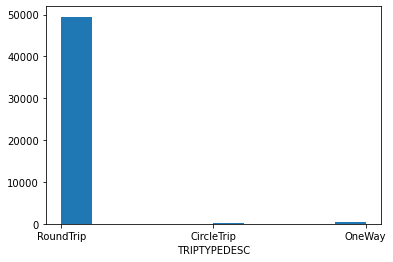

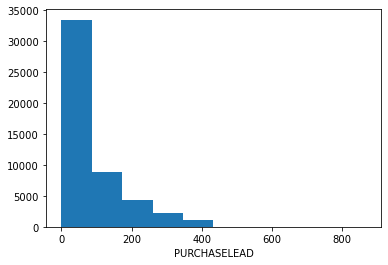

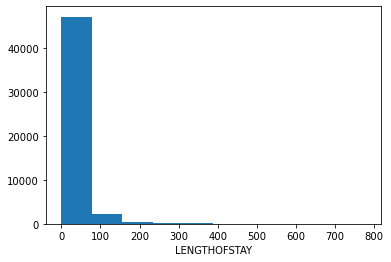

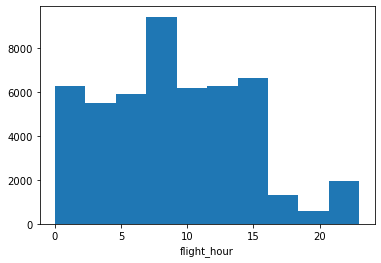

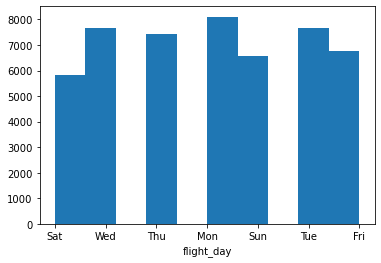

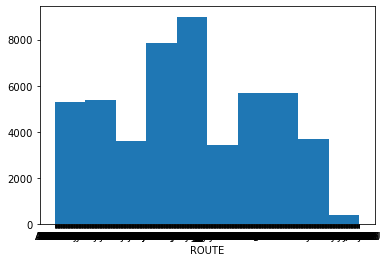

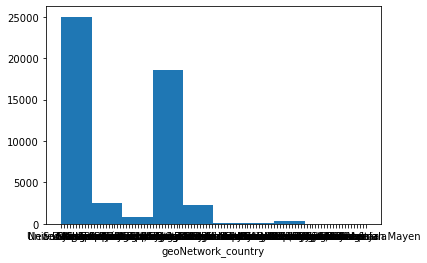

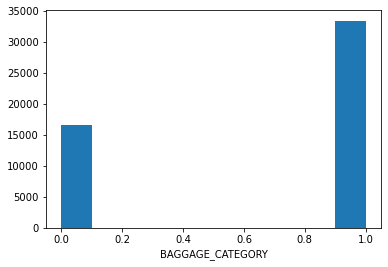

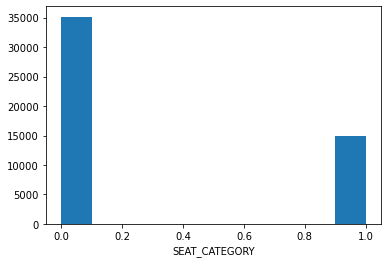

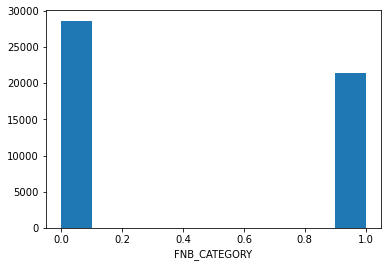

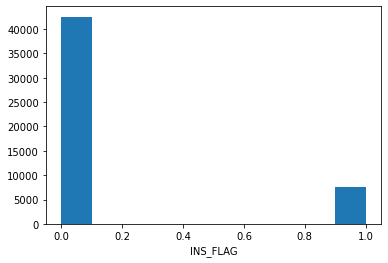

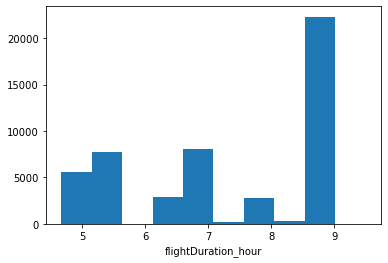

In [ ]:
# Histograms
for i in data.columns:
    plt.hist(data[i])
    plt.xlabel(i)
    plt.show()

<AxesSubplot:>

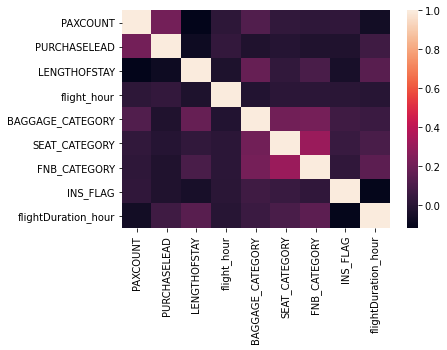

In [ ]:
# Correlation Matrix
sns.heatmap(data.corr())

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

string_cols = ['SALESCHANNEL','TRIPTYPEDESC','flight_day','ROUTE','geoNetwork_country']

for i in string_cols:
    le.fit(data[i])
    data[i] = le.transform(data[i])
    
#data.head(3)

In [ ]:
num_cols = list(data.columns)

for i in string_cols:
    num_cols.remove(i)
    
num_cols.remove('INS_FLAG')

### Train & Test Data

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(['INS_FLAG'], axis=1)
y = data['INS_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## LightGBM 

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
clf = LGBMClassifier(is_unbalance = True,
                     boosting_type='dart', 
                    learning_rate = 0.1, 
                    objective= 'binary', 
                    n_estimators = 1000, 
                    reg_alpha=10.0, 
                    reg_lambda=100)

clf.fit(X_train.values,y_train)

predictions = clf.predict(X_test)

In [ ]:
act = y_test.values
predict = predictions
confusion_matrix_custom(act, predict)
print("F1 Score : {}".format(f1_score(y_test,predictions)))

Actual, Predicted Observations:   5000 5000
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       2975            1259
Actual Y       184            582
--------------------------------------------
Total observations  :   5000
False Positives     :   1259
False Negatives     :   184
Overall Accuracy    :   71.14 %
Sensitivity/Recall  :   75.98 %
Specificity         :   70.26 %
Precision           :   31.61 %
--------------------------------------------
F1 Score : 0.4464902186421174


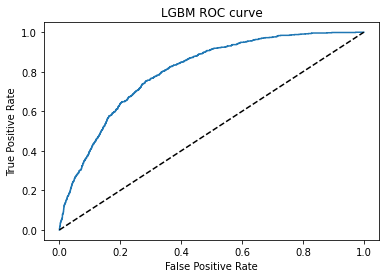

The AUC ROC Score is 0.7312181877157564


In [ ]:
probs = clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 

plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC curve')

# show the plot
plt.show()

print("The AUC ROC Score is {}".format(roc_auc_score(y_test, predictions)))

## Grid Search for LightGBM 

In [ ]:
estimator = lgb.LGBMClassifier(boosting_type='gbdt', 
                                learning_rate = 0.01, 
                                objective= 'binary', 
                                n_estimators = 1000, 
                                reg_alpha=0.0, 
                                reg_lambda=0.0, 
                                is_unbalanced = True)


param_grid = {
    'n_estimators': [x for x in range(1,200,10)],
    'learning_rate': [0.1, 0.001, 0.01],
             }

gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

In [ ]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

In [ ]:
# Optimized Parameters
# 'reg_alpha': 0,  # L1 regularization term on weights
# 'reg_lambda': 0,  # L2 regularization term on weights
            
gbm = lgb.LGBMClassifier(boosting_type='dart', 
                        learning_rate = 0.1, 
                         n_estimators = 1000, 
                         objective='binary',
                         reg_alpha=0.0, 
                         reg_lambda=100.0, 
                         is_unbalanced = True,
                         random_state=1000)

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'], early_stopping_rounds=20)

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

In [ ]:
act = y_test.values
predict = y_pred
confusion_matrix_custom(act, predict)

In [ ]:
#probs = gbm.predict_proba(X_test)  
#probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, y_pred) 

plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC curve')

# show the plot
plt.show()

print("The AUC ROC Score is {}".format(roc_auc_score(y_test, predictions)))

# Comparison 

## SMOTE

In [ ]:
# import the SMOTE
from imblearn.over_sampling import SMOTE

# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

# fit the object to our training data
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

from collections import Counter
counter = Counter(y_train_smote)
print(counter)

Counter({0: 38288, 1: 38288})


## AdaBoost Classifier

In [ ]:
print ('**** AdaBoost Classifier ****') 
from sklearn.ensemble.weight_boosting import AdaBoostClassifier

# Function to train the model 
def train_ada_model(x_vals, y_vals):
    ada_model = AdaBoostClassifier()
    ada_model.fit(x_vals, y_vals)
    return ada_model

# Training
ada_model = train_ada_model(X_train_smote, y_train_smote)

train_accuracy = model_accuracy(ada_model, X_train_smote, y_train_smote)

# Testing
test_accuracy = model_accuracy(ada_model, X_test, y_test)

print ('********')
print ("Training Accuracy : ", round(train_accuracy * 100, 2), "%")
print ('********')

# Model accuracy: Score and construct Confusion matrix for Test data
act = y_test.values
predict = score_data(ada_model, X_test)

# Print Count of Actual fails, Predicted fails
# Print Confusion matrix
print ('********')
confusion_matrix_custom(act, predict)

print ('********')
print("F1 Score : {}".format(f1_score(y_test,predict)))
print ('********')

**** AdaBoost Classifier ****


C:\Users\Ishan Jain\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


********
Training Accuracy :  74.97 %
********
********
Actual, Predicted Observations:   5000 5000
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       2983            1251
Actual Y       352            414
--------------------------------------------
Total observations  :   5000
False Positives     :   1251
False Negatives     :   352
Overall Accuracy    :   67.94 %
Sensitivity/Recall  :   54.05 %
Specificity         :   70.45 %
Precision           :   24.86 %
--------------------------------------------
********
F1 Score : 0.34060057589469356
********


## MLP Classifier

In [ ]:
print ('**** MLPClassifier ****') 
from sklearn.neural_network.multilayer_perceptron import MLPClassifier

# Function to train mlp_model 
def train_mlp(x_vals, y_vals):
    mlp_model = MLPClassifier(alpha=1, max_iter=1000)
    mlp_model.fit(x_vals, y_vals)
    return mlp_model

# Training mlp_model
mlp_model = train_mlp(X_train_smote, y_train_smote)

train_accuracy = model_accuracy(mlp_model, X_train_smote, y_train_smote)

# Testing the mlp
test_accuracy = model_accuracy(mlp_model, X_test, y_test)

print ('********')
print ("Training Accuracy : ", round(train_accuracy * 100, 2), "%")
print ('********')

# Model accuracy: Score and construct Confusion matrix for Test data
act = y_test.values
predict = score_data(mlp_model, X_test)

# Print Count of Actual fails, Predicted fails
# Print Confusion matrix
print ('********')
confusion_matrix_custom(act, predict)

print ('********')
print("F1 Score : {}".format(f1_score(y_test,predict)))
print ('********')


**** MLPClassifier ****
********
Training Accuracy :  70.46 %
********
********
Actual, Predicted Observations:   5000 5000
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       2900            1334
Actual Y       338            428
--------------------------------------------
Total observations  :   5000
False Positives     :   1334
False Negatives     :   338
Overall Accuracy    :   66.56 %
Sensitivity/Recall  :   55.87 %
Specificity         :   68.49 %
Precision           :   24.29 %
--------------------------------------------
********
F1 Score : 0.33860759493670883
********


## Gaussian Naive Bayes

In [ ]:
print ('**** GaussianNB ****') 
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB


# Function to train the model 
def train_bnb_model(x_vals, y_vals):
    #bnb_model = BernoulliNB()
    bnb_model = GaussianNB()
    bnb_model.fit(x_vals, y_vals)
    return bnb_model


# Training
bnb_model = train_bnb_model(X_train_smote, y_train_smote)

train_accuracy = model_accuracy(bnb_model, X_train_smote, y_train_smote)

# Testing 
test_accuracy = model_accuracy(bnb_model, X_test, y_test)

print ('********')
print ("Training Accuracy : ", round(train_accuracy * 100, 2), "%")
print ('********')

# Model accuracy: Score and construct Confusion matrix for Test data
act = y_test.values
predict = score_data(bnb_model, X_test)

# Print Count of Actual fails, Predicted fails
# Print Confusion matrix
print ('********')
confusion_matrix_custom(act, predict)

print ('********')
print("F1 Score : {}".format(f1_score(y_test,predict)))
print ('********')


**** GaussianNB ****
********
Training Accuracy :  61.86 %
********
********
Actual, Predicted Observations:   5000 5000
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       1501            2733
Actual Y       203            563
--------------------------------------------
Total observations  :   5000
False Positives     :   2733
False Negatives     :   203
Overall Accuracy    :   41.28 %
Sensitivity/Recall  :   73.5 %
Specificity         :   35.45 %
Precision           :   17.08 %
--------------------------------------------
********
F1 Score : 0.2772033481043821
********


# Summary